## Simple East West SST Trend Analysis for CMIP6

### Import packages

In [1]:
import intake
import pprint
import numpy as np
import util
import warnings
import xesmf as xe
import xarray as xr
import matplotlib.pyplot as plt
from IPython.utils import io

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


### Define some parameters

In [2]:
# CMIP Metadata
# These are defined as lists, but this code was written assuming one
# value in several places
var_ids = ['ts']  # variable to analyze
exp_ids = ['historical']  # experiment to analyze
table_ids = ["Amon"]  # table to use
activity_ids = ["CMIP"]  # activity to use
catalog_json_file = "../catalogs/glade-cmip6.json"  # catalog file

# Analysis Options
start_year = 1979  # start of analysis period
end_year = 2014  # last year of analysis period
west_lat_bounds = [-2.5, 2.5]  # western pacific box lat bounds
west_lon_bounds = [117, 173]  # western pacific box lon bounds
east_lat_bounds = [-2.5, 2.5]  # eastern pacific box lat bounds
east_lon_bounds = [205, 275]  # eastern pacific box lon bounds
reftime = 432  # number of time points expected

# This is mainly for this notebook, where the warnings are distracting.
# Show them once.
# warnings.filterwarnings(action='once') # I think this didn't work
warnings.filterwarnings('ignore')

### Create target grid for trend maps

In [3]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89., 90., 2.0)),
                     'lon': (['lon'], np.arange(1., 360., 2.0)),
                     }
                    )

### Search the catalog

In [4]:
col = intake.open_esm_datastore(catalog_json_file)
cat = col.search(activity_id=activity_ids, experiment_id=exp_ids,
                 variable_id=var_ids, table_id=table_ids)
uni_dict = cat.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 1, 'values': ['historical']},
 'source_id': {'count': 26,
               'values': ['CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1',
                          'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2', 'FGOALS-g3',
                          'SAM0-UNICON', 'UKESM1-0-LL', 'HadGEM3-GC31-LL',
                          'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-1-H', 'GISS-E2-1-G',
                          'CanESM5', 'E3SM-1-0', 'CAMS-CSM1-0', 'MCM-UA-1-0',
                          'EC-Earth3', 'EC-Earth3-Veg', 'MRI-ESM2-0', 'NESM3',
                          'MIROC-ES2L', 'MIROC6', 'IPSL-CM6A-LR',
                          'NorESM2-LM']},
 'table_id': {'count': 1, 'values': ['Amon']}}


### Get models

In [5]:
models = list(uni_dict['source_id'].values())[1]
print(str(len(models)) + ' models in analysis')

26 models in analysis


### Create CMIP6 dataset (loop over models and realizations)

#### Pre-allocate some output 

In [6]:
trend_maps = xr.Dataset() # xarray dataset to store trend maps
dataDict = {} # trend dictionary

#### Loop over all datasets and compute box statistics and trend maps

In [7]:
# loop over all models
for i, model in enumerate(models):
    print(model + ' (' + str(i+1) + '/' + str(len(models)) + ')')
    # get a catalog for each model (to determine what realizations
    # are available for each model)
    catModel = col.search(source_id=model, activity_id=activity_ids,
                          experiment_id=exp_ids, variable_id=var_ids,
                          table_id=table_ids);
    uni_dict = catModel.unique(['source_id', 'experiment_id', 'table_id',
                                'member_id'])
    # get a list of the realizations
    rips = list(uni_dict['member_id'].values())[1]
    # loop over all realizations
    for j, rip in enumerate(rips):
        print('.', end='')
        # get a catalog for one model / realization
        catInner = col.search(source_id=model, member_id=rip,
                              activity_id=activity_ids, experiment_id=exp_ids,
                              variable_id=var_ids, table_id=table_ids);
        # create a dataset
        with io.capture_output() as captured:
          ds = catInner.to_dataset_dict()
        # get the key (there should just be one)
        key = list(ds.keys())[0]
        ds = ds[key] # subset the dataset
        dsvar = ds[var_ids[0]].isel(member_id=0)  # select data for variable
        # subset the time
        dsvar = dsvar.sel(time=slice(str(start_year) + '-01-01',
                                     str(end_year) + '-12-30'))
        # make sure the dataset has the appropriate length (or skip)
        if dsvar.shape[0] != reftime:
            continue
        # xESMF can't handle 'longitude' yet
        # https://github.com/JiaweiZhuang/xESMF/issues/72
        if 'longitude' in dsvar.dims:
          dsvar = dsvar.rename({'latitude': 'lat'})
          dsvar = dsvar.rename({'longitude': 'lon'})
        # get trend map
        trend_map = util.spatial_trends(dsvar)
        # regrid to common grid
        with io.capture_output() as captured:
          regridder = xe.Regridder(trend_map, ds_out, 'bilinear', reuse_weights=True)
        trend_regrid = regridder(trend_map)
        # get spatial average trends (from trend maps)
        m_west = util.simple_spatial_average(trend_regrid,
                                             lat_bounds=west_lat_bounds,
                                             lon_bounds=west_lon_bounds).item()
        m_east = util.simple_spatial_average(trend_regrid,
                                             lat_bounds=east_lat_bounds,
                                             lon_bounds=east_lon_bounds).item()
        m_tropics = util.simple_spatial_average(trend_regrid,
                                                lat_bounds=[-30, 30]).item()
        m_global = util.simple_spatial_average(trend_regrid).item()
        # store data in dictionary
        if model not in dataDict:
          dataDict[model] = {}
        dataDict[model][rip] = {'east': m_east, 'west': m_west, 'globe': m_global, 'tropics': m_tropics}
        trend_maps[model + '_' + rip] = trend_regrid
    print()

CNRM-CM6-1 (1/26)
..............
CNRM-ESM2-1 (2/26)
.....
BCC-ESM1 (3/26)
...
BCC-CSM2-MR (4/26)
...
CESM2-WACCM (5/26)
...
CESM2 (6/26)
...........
FGOALS-g3 (7/26)
...
SAM0-UNICON (8/26)
.
UKESM1-0-LL (9/26)
.........
HadGEM3-GC31-LL (10/26)
....
GFDL-ESM4 (11/26)
.
GFDL-CM4 (12/26)
.
GISS-E2-1-H (13/26)
..........
GISS-E2-1-G (14/26)
......................
CanESM5 (15/26)
............................................
E3SM-1-0 (16/26)
.....
CAMS-CSM1-0 (17/26)
..
MCM-UA-1-0 (18/26)
.
EC-Earth3 (19/26)
............
EC-Earth3-Veg (20/26)
....
MRI-ESM2-0 (21/26)
.....
NESM3 (22/26)
....
MIROC-ES2L (23/26)
.
MIROC6 (24/26)
..........
IPSL-CM6A-LR (25/26)
................................
NorESM2-LM (26/26)
...


### Get list of model trends in W-E gradient

In [8]:
# Get array of E-W model trends
model_grad = []
for key in dataDict.keys():
  for keyInner in dataDict[key].keys():
    # get values from data dictionary
    w = dataDict[key][keyInner]['west']
    e = dataDict[key][keyInner]['east']
    model_grad.append((w-e)*10)

model_grad = np.array(model_grad) # cast to array

### Get HadSST3 observations (pre-downloaded)

In [9]:
# pre-allocate data
had_obs = []

# Loop over 100 realizations
for i in range(1, 101):
    # load data
    ds = xr.load_dataset('../data/HadSST.3.1.1.0.anomalies.' + str(i) + '.nc')
    dsvar = ds.sst.sel(time=slice(str(start_year) + '-01-01',
                                  str(end_year) + '-12-30'))
    time_decimal = util.get_decimal_time(dsvar)
    # get west box time series (note larger bounds)
    dsvar_west = dsvar.sel(longitude=slice(west_lon_bounds[0], west_lon_bounds[1]), latitude=slice(5, -5))
    # simple average...
    tsw = np.nanmean(np.nanmean(np.array(dsvar_west), axis=2), axis=1)
    tsw = xr.DataArray(tsw, coords=[dsvar.time], dims=['time'])
    tsw_anom = util.get_anomaly(tsw)
    # get west trend
    m_west = np.polyfit(time_decimal, np.array(tsw_anom), 1)[0]
    # update boundaries to -180 - 180 longitude coordinates
    eb1 = -180. + (east_lon_bounds[0] - 180.)
    eb2 = -180. + (east_lon_bounds[1] - 180.)
    # get east box time series (note larger bounds)
    dsvar_east = dsvar.sel(longitude=slice(eb1, eb2), latitude=slice(5, -5))
    # simple average...
    tse = np.nanmean(np.nanmean(np.array(dsvar_east), axis=2), axis=1)
    tse = xr.DataArray(tse, coords=[dsvar.time], dims=['time'])
    tse_anom = util.get_anomaly(tse)
    # get east trend
    m_east = np.polyfit(time_decimal, np.array(tse_anom), 1)[0]
    had_obs.append((m_west - m_east)*10)

### Use Opendap to get ERSST, COBE, HadISST

In [10]:
ds = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc')
dsvar = ds.sst
dsvar = dsvar.sel(time=slice('1979-01-01', '2014-12-31'))
trend_map = util.spatial_trends(dsvar)
m_west_ersst = util.simple_spatial_average(trend_map,
                                     lat_bounds=west_lat_bounds,
                                     lon_bounds=west_lon_bounds).item()
m_east_ersst = util.simple_spatial_average(trend_map,
                                     lat_bounds=east_lat_bounds,
                                     lon_bounds=east_lon_bounds).item()
ds.close()

ds = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/COBE2/sst.mon.mean.nc')
dsvar = ds.sst
dsvar = dsvar.sel(time=slice('1979-01-01', '2014-12-31'))
trend_map = util.spatial_trends(dsvar)
m_west_cobe = util.simple_spatial_average(trend_map,
                                     lat_bounds=west_lat_bounds,
                                     lon_bounds=west_lon_bounds).item()
m_east_cobe = util.simple_spatial_average(trend_map,
                                     lat_bounds=east_lat_bounds,
                                     lon_bounds=east_lon_bounds).item()
ds.close()

# For some reason this isn't working with xarray
# ds = xr.open_dataset('https://oceanwatch.pfeg.noaa.gov/thredds/dodsC/HadleyCenter/HadISST')
# dsvar = ds.sst
# dsvar = dsvar.sel(time=slice('1979-01-01', '2014-12-31'))
# trend_map = util.spatial_trends(dsvar)
# m_west_hadisst = util.simple_spatial_average(trend_map,
#                                      lat_bounds=west_lat_bounds,
#                                      lon_bounds=west_lon_bounds).item()
# m_east_hadisst = util.simple_spatial_average(trend_map,
#                                      lat_bounds=east_lat_bounds,
#                                      lon_bounds=east_lon_bounds).item()
# ds.close()

### Create a box plot of the contrast in E-W trends

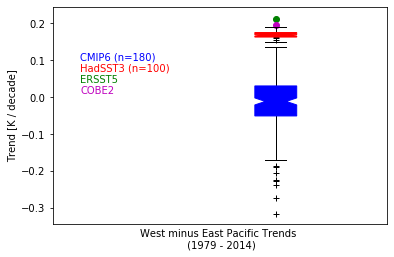

In [11]:
# Plot data
plt.boxplot(model_grad, sym='.', notch=True, patch_artist=True, boxprops=dict(facecolor='blue', color='blue'), medianprops=dict(color='blue'))
plt.boxplot(had_obs, notch=True, patch_artist=True, boxprops=dict(facecolor='red', color='red'), medianprops=dict(color='red'))
plt.scatter(1, (m_west_ersst - m_east_ersst)*10, color='g')
plt.scatter(1, (m_west_cobe - m_east_cobe)*10, color='m')
# plt.scatter(1, (m_west_hadisst - m_east_hadisst)*10, color='pink')
plt.text(0.3, 0.1, 'CMIP6 (n=' + str(len(model_grad)) + ')', color='b')
plt.text(0.3, 0.07, 'HadSST3 (n=100)', color='r')
plt.text(0.3, 0.04, 'ERSST5', color='g')
plt.text(0.3, 0.01, 'COBE2', color='m')
# plt.text(0.3, -0.02, 'HadISST1', color='pink')
plt.xlabel('West minus East Pacific Trends \n (1979 - 2014)')
plt.ylabel('Trend [K / decade]')
plt.xticks([])
plt.xlim(0.2, 1.4)
plt.savefig('trend_distribution.pdf', bbox_inches='tight')
plt.show()